In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


In [2]:
df = pd.read_excel('Opta.xls')

Preprocessing

In [3]:
rows_missing = df[df['Player Forename'].isnull()]
selected_clumns = ['Player ID', 'Player Surname', 'Player Forename', 'Team']
rows_missing = rows_missing[selected_clumns]
unique_missing = rows_missing['Player Surname'].unique().tolist()

In [4]:
# Filter rows with missing values in the 'Player Forename' column and unique Player Surnames
rows_to_transform = df[df['Player Forename'].isnull() & df['Player Surname'].isin(unique_missing)]

# Define a function to split names
def split_name(full_name):
    if ' ' not in full_name:  # Single name
        return ('', full_name)
    else:
        parts = full_name.split(' ')
        if len(parts) == 2:  # Western name
            return (parts[0], parts[1])
        else:  # Asian name
            return (parts[1], parts[0])  # Swap the positions for Asian names

# Apply the split_name function and create two new columns
split_names = rows_to_transform['Player Surname'].apply(split_name).apply(pd.Series)
split_names.columns = ['Player Forename', 'Player Surname']

# Update df with the modified rows
df.update(split_names)

# List of the Asian names that were swapped
specific_names = ['Ji Dong-Won', 'Lee Chung-Yong', 'Park Chu-Young', 'Park Ji-Sung']

# Iterate through the DataFrame and swap values for the specific names
for name in specific_names:
    surname, forename = name.split()
    df.loc[df['Player Surname'] == forename, 'Player Surname'], df.loc[df['Player Forename'] == surname, 'Player Forename'] = surname, forename

In [5]:
# List of columns to exclude from summation
exclude_columns = [
    'Index', 'Date', 'Player ID', 'Player Surname', 'Player Forename', 'Team',
    'Team Id', 'Opposition', 'Opposition id', 'Venue', 'Position Id',
    'Team Formation', 'Position in Formation', 'CompId', 'SeasId'
]

# Identify columns to sum (exclude those in the exclude_columns list)
sum_columns = [col for col in df.columns if col not in exclude_columns]

# Group by Player ID and sum the data to get stats per player for the whole season
summarized_df = df.groupby(['Player ID', 'Player Forename', 'Player Surname'])[sum_columns].sum().reset_index()

In [6]:
ylabel = pd.read_excel('Transfermarkt.xlsx')

In [7]:
# Merge names in order to merge both datasets on the full player name
summarized_df['player_name'] = summarized_df['Player Forename'] + ' ' + summarized_df['Player Surname']

# Some names differ, this variable contains the players where the name differs between the 2 datasets
missing_names = pd.read_excel('Missing Players.xlsx')

# Merge the dataframes based on Player Forename and Player Surname
temp_df = pd.merge(summarized_df, missing_names, on=['Player Forename', 'Player Surname'], how='left', suffixes=('', '_missing'))

# Update player_name in summarized_df with values from 'ylabel name' in missing_names
summarized_df['player_name'] = temp_df['ylabel name'].combine_first(temp_df['player_name'])

# Merge summarized_df with ylabel

# Filter ylabel based on the condition season_start_year == 2011
filtered_ylabel = ylabel[ylabel['season_start_year'] == 2011]


# Merge the dataframes based on player_name and the filtered ylabel
merged_df = pd.merge(summarized_df, filtered_ylabel[['player_name', 'player_position', 'player_dob', 'player_nationality',
                                                     'player_height_mtrs', 'player_foot', 'player_market_value_euro']],
                     on='player_name', how='left')

In [8]:
## Adjust player position
merged_df.loc[merged_df['player_name'] == 'David Jones', 'player_position'] = 'Central Midfield'

Create variables

In [9]:
## Transform Date of Birth to Age on the end of the 2011/2012 season to use it for plots
from datetime import datetime
merged_df['player_dob'] = pd.to_datetime(merged_df['player_dob'])

## end of season date 
end_date = datetime(2012, 5, 13)

# Age on end_date
merged_df['age'] = merged_df['player_dob'].apply(lambda dob: (end_date - dob).days // 365)



In [10]:
# Create shots on target excl goals
merged_df['Shots on target excl goals'] = merged_df['Shots On Target inc goals'] - merged_df[ 'Goals']

merged_df is saved as merged_data.csv

Final dataset

In [11]:
df = pd.read_csv("merged_data.csv").dropna()
df.drop(columns=["Player ID","Player Forename","Player Surname","player_name","player_dob"], inplace=True)

Encoding categorical variables

In [12]:
## 72 different nationalities
nationality_count = df['player_nationality'].value_counts()
## Group these per continent due to the low frequency per country, only keep England separate. Central american countries will be put with south america due to low freq.
## Asia and Oceania will be merged into Other
continent_mapping = {'England' : 'England',
                     'Ireland': 'Europe',
                     'France': 'Europe',
                     'Scotland' : 'Europe',
                     'Wales' : 'Europe',
                     'Spain' : 'Europe',
                     'Argentina': 'South America',
                     'Netherlands' : 'Europe',
                     'Nigeria' : 'Africa',
                     'Belgium' : 'Europe',
                     'Senegal': 'Africa',
                     'United States' : 'North America',
                     'Northern Ireland' : 'Europe',
                     'Denmark' : 'Europe',
                     'Portugal' : 'Europe',
                     'Italy' : 'Europe',
                     'Russia' : 'Europe',
                     "Cote d'Ivoire" : 'Africa',
                     'Sweden' : 'Europe',
                     'Cameroon' : 'Africa',
                     'Croatia' : 'Europe',
                     'Ghana' : 'Africa',
                     'Czech Republic' : 'Europe',
                     'Iceland' : 'Europe',
                     'Australia' : 'Other',
                     'Chile' : 'South America',
                     'Serbia' : 'Europe',
                     'Hungary': 'Europe',
                     'Korea, South' : 'Other',
                     'Brazil' : 'South America',
                     'Jamaica' : 'Caribbean',
                     'Greece' : 'Europe',
                     'DR Congo' : 'Africa',
                     'Austria' : 'Europe',
                     'Switzerland' : 'Europe',
                     'Norway' : 'Europe',
                     'Germany' : 'Europe',
                     'Mali' : 'Africa',
                     'Barbados' : 'Caribbean',
                     'Uruguay' : 'South America',
                     'Mexico' : 'North America',
                     'Bosnia-Herzegovina' : 'Europe',
                     'Israel' : 'Other',
                     'Honduras' : 'North America',
                     'Morocco' : 'Africa',
                     'Montenegro' : 'Europe',
                     'Canada' : 'North America',
                     'South Africa' : 'Africa',
                     'French Guiana' : 'South America',
                     'Japan' : 'Other',
                     'Togo' : 'Africa',
                     'Slovenia' : 'Europe',
                     'Algeria' : 'Africa',
                     'Poland' : 'Europe',
                     'Finland' : 'Europe',
                     'Guyana' : 'South America',
                     'Gibraltar' : 'Europe',
                     'Grenada' : 'Caribbean',
                     'Paraguay' : 'South America',
                     'Colombia' : 'South America',
                     'Curacao' : 'Caribbean',
                     'Guadeloupe' : 'Caribbean',
                     'Egypt' : 'Africa',
                     'Costa Rica' : 'South America',
                     'Benin' : 'Africa',
                     'Oman' : 'Other',
                     'Romania' : 'Europe',
                     'Slovakia' : 'Europe',
                     'Ecuador' : 'South America',
                     'Congo' : 'Africa',
                     'Trinidad and Tobago' : 'Caribbean',
                     'Turkey' : 'Europe'
                     }

def country_to_continent(nationality):
    return continent_mapping.get(nationality, 'other')

df['player_continent'] = df['player_nationality'].apply(country_to_continent)

df.drop(columns=["player_nationality"], inplace=True)

In [13]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import r2_score
from tqdm import tqdm
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV

In [14]:
# Check if get_dummies or onehotencoder performs best
categorical_columns = ['player_continent', 'player_position', 'player_foot']
df_encoded = pd.get_dummies(df, columns=categorical_columns, drop_first=True)

In [15]:
missing_values = df_encoded.isnull().sum()
missing_values = missing_values[missing_values > 0]
missing_values

Series([], dtype: int64)

Correlation matrix

In [16]:
corr_matrix = df_encoded.corr()

In [17]:
corr_with_target = corr_matrix['player_market_value_euro'].sort_values(ascending=False)

Selecting Features

In [18]:
core_features = [
    # Continents; Africa left out for dummy codes
    'player_continent_South America', 'player_continent_England',
    'player_continent_Europe', 'player_continent_Other',
    'player_continent_Caribbean', 'player_continent_North America',
# Positions; Attacking Midfield left out for dummy codes
    'player_position_Goalkeeper', 'player_position_Left-Back', 'player_position_Right-Back', 'player_position_Centre-Back',
    'player_position_Central Midfield', 'player_position_Left Midfield', 'player_position_Right Midfield', 'player_position_Defensive Midfield',
    'player_position_Right Winger', 'player_position_Second Striker', 'player_position_Centre-Forward', 'player_position_Left Winger'
]

additional_features = [
    'age', 'Duels won', 'Interceptions', 'Yellow Cards', 'player_height_mtrs', 'Goals', 'Through Ball', 'Successful Dribbles',
    'Shots on target excl goals', 'Big Chances', 'Touches open play final third', 'Assists',
    'Key Passes', 'Saves Made']


In [19]:
interested_features2 = core_features + additional_features

Model training - All features

In [20]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [21]:
# All features
X = df_encoded.drop('player_market_value_euro', axis=1)
#Selected features
X_selected = df_encoded[interested_features2]
X_core = df_encoded[core_features]
y = df_encoded['player_market_value_euro']


In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Linear Regression

In [23]:
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

y_pred_lr_train = linear_model.predict(X_train)
y_pred_lr = linear_model.predict(X_test)

r2_lr_train = r2_score(y_train, y_pred_lr_train)
r2_lr = r2_score(y_test, y_pred_lr)
mse_lr = mean_squared_error(y_test, y_pred_lr)
mae_lr = mean_absolute_error(y_test, y_pred_lr)
generalization_gap_lr = r2_lr_train - r2_lr

Random Forest Regression

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1517903001.py:44: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1517903001.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


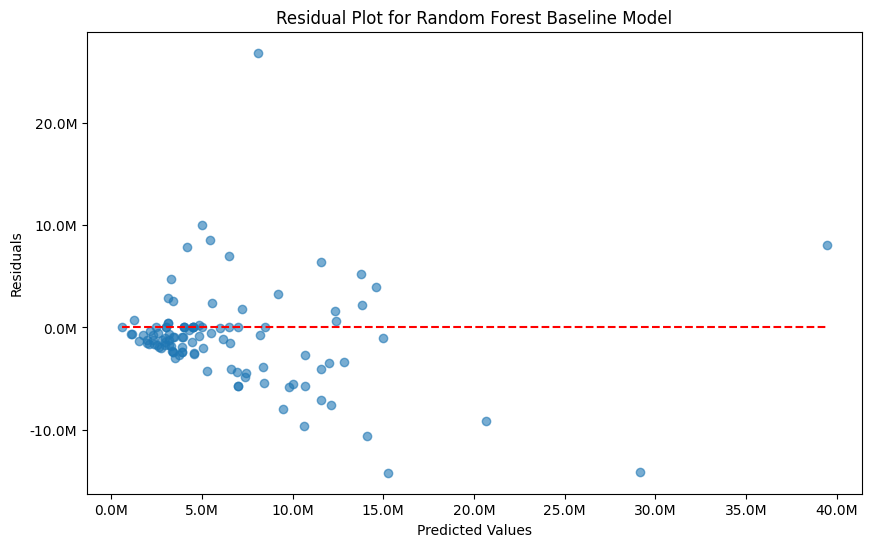

In [24]:
param_grid_rf_baseline = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30]
}
rf_model_baseline = RandomForestRegressor(random_state=42)
rf_random_baseline = RandomizedSearchCV(estimator=rf_model_baseline, param_distributions=param_grid_rf_baseline, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
rf_random_baseline.fit(X_train, y_train)
best_params_rf_baseline = rf_random_baseline.best_params_

# Best Parameters
rf_model_baseline_best = RandomForestRegressor(**best_params_rf_baseline, random_state=42)
rf_model_baseline_best.fit(X_train, y_train)
y_pred_rf_baseline_train = rf_model_baseline_best.predict(X_train)
y_pred_rf_baseline_test = rf_model_baseline_best.predict(X_test)

r2_rf_baseline_train = r2_score(y_train, y_pred_rf_baseline_train)
r2_rf_baseline_test = r2_score(y_test, y_pred_rf_baseline_test)
mse_rf_baseline_best = mean_squared_error(y_test, y_pred_rf_baseline_test)
mae_rf_baseline_best = mean_absolute_error(y_test, y_pred_rf_baseline_test)
generalization_gap_rf_baseline = r2_rf_baseline_train - r2_rf_baseline_test

# Feature Importance
rf_importances_baseline = rf_model_baseline_best.feature_importances_
feature_names_baseline = X_train.columns
feature_importance_rf_baseline = pd.DataFrame({
    'Feature': feature_names_baseline,
    'Importance': rf_importances_baseline
}).sort_values(by='Importance', ascending=False)

# Residual Plot
residuals_rf_baseline = y_test - y_pred_rf_baseline_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf_baseline_test, residuals_rf_baseline, alpha=0.6)
plt.hlines(0, min(y_pred_rf_baseline_test), max(y_pred_rf_baseline_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Baseline Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

XGBoost

In [25]:
param_grid_xgb_baseline = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb_model_baseline = xgb.XGBRegressor(random_state=42)
xgb_random_baseline = RandomizedSearchCV(estimator=xgb_model_baseline, param_distributions=param_grid_xgb_baseline, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
xgb_random_baseline.fit(X_train, y_train)
best_params_xgb_baseline = xgb_random_baseline.best_params_

# Best Parameters
xgb_model_baseline_best = xgb.XGBRegressor(**best_params_xgb_baseline, random_state=42)
xgb_model_baseline_best.fit(X_train, y_train)
y_pred_xgb_baseline_train = xgb_model_baseline_best.predict(X_train)
y_pred_xgb_baseline_test = xgb_model_baseline_best.predict(X_test)

r2_xgb_baseline_train = r2_score(y_train, y_pred_xgb_baseline_train)
r2_xgb_baseline_test = r2_score(y_test, y_pred_xgb_baseline_test)
mse_xgb_baseline_best = mean_squared_error(y_test, y_pred_xgb_baseline_test)
mae_xgb_baseline_best = mean_absolute_error(y_test, y_pred_xgb_baseline_test)
generalization_gap_xgb_baseline = r2_xgb_baseline_train - r2_xgb_baseline_test

# Feature Importance
importances_xgb_baseline_best = xgb_model_baseline_best.feature_importances_
feature_names_xgb_baseline = X_train.columns
feature_importance_df_xgb_baseline = pd.DataFrame({
    'Feature': feature_names_xgb_baseline,
    'Importance': importances_xgb_baseline_best
}).sort_values(by='Importance', ascending=False)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


ElasticNet

In [26]:
param_grid_elasticnet_baseline = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 35 is smaller than n_iter=100. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 35 candidates, totalling 350 fits


c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.088e+15, tolerance: 2.862e+12
  model = cd_fast.enet_coordinate_descent(
c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.088e+15, tolerance: 2.862e+12
  model = cd_fast.enet_coordinate_descent(
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3150484875.py:35: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.f

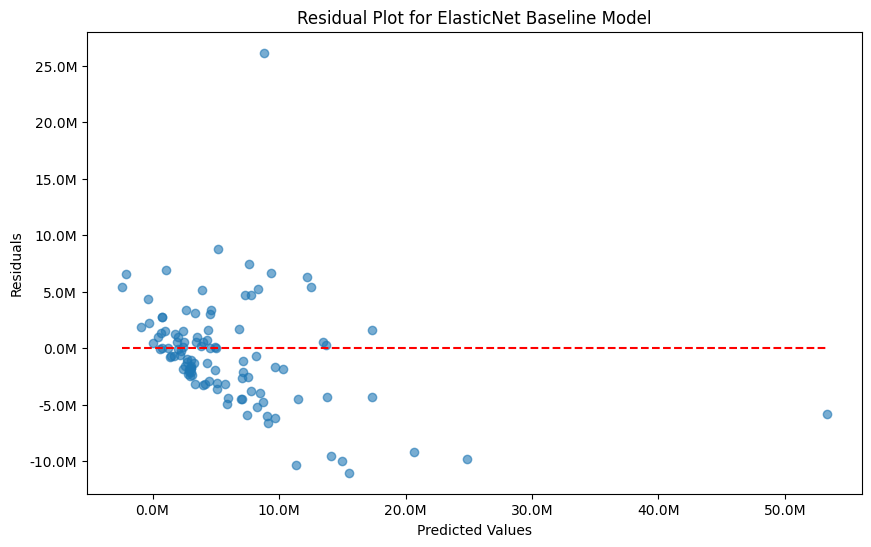

In [27]:
elasticnet_model_baseline = ElasticNet(random_state=42)
elasticnet_random_baseline = RandomizedSearchCV(estimator=elasticnet_model_baseline, param_distributions=param_grid_elasticnet_baseline, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
elasticnet_random_baseline.fit(X_train, y_train)
best_params_elasticnet_baseline = elasticnet_random_baseline.best_params_

# Best Parameters
elasticnet_model_baseline_best = ElasticNet(**best_params_elasticnet_baseline, random_state=42)
elasticnet_model_baseline_best.fit(X_train, y_train)
y_pred_elasticnet_baseline_train = elasticnet_model_baseline_best.predict(X_train)
y_pred_elasticnet_baseline_test = elasticnet_model_baseline_best.predict(X_test)

r2_elasticnet_baseline_train = r2_score(y_train, y_pred_elasticnet_baseline_train)
r2_elasticnet_baseline_test = r2_score(y_test, y_pred_elasticnet_baseline_test)
mse_elasticnet_baseline_best = mean_squared_error(y_test, y_pred_elasticnet_baseline_test)
mae_elasticnet_baseline_best = mean_absolute_error(y_test, y_pred_elasticnet_baseline_test)
generalization_gap_elasticnet_baseline = r2_elasticnet_baseline_train - r2_elasticnet_baseline_test

# Feature Importance
elasticnet_coefficients_baseline = elasticnet_model_baseline_best.coef_
feature_names_elasticnet_baseline = X_train.columns
feature_importance_df_elasticnet_baseline = pd.DataFrame({
    'Feature': feature_names_elasticnet_baseline,
    'Coefficient': elasticnet_coefficients_baseline
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Residual Plot for ElasticNet Baseline Model
residuals_elasticnet_baseline_best = y_test - y_pred_elasticnet_baseline_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_elasticnet_baseline_test, residuals_elasticnet_baseline_best, alpha=0.6)
plt.hlines(0, min(y_pred_elasticnet_baseline_test), max(y_pred_elasticnet_baseline_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for ElasticNet Baseline Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()


Model Training - Selected Features

In [28]:
X_train_selected, X_test_selected, y_train_selected, y_test_selected = train_test_split(X_selected, y, test_size=0.2, random_state=42)

Linear Regression Selected

In [29]:
linear_model_selected = LinearRegression()
linear_model_selected.fit(X_train_selected, y_train_selected)

y_pred_lr_selected_train = linear_model_selected.predict(X_train_selected)
y_pred_lr_selected = linear_model_selected.predict(X_test_selected)

r2_lr_selected_train = r2_score(y_train_selected, y_pred_lr_selected_train)
r2_lr_selected = r2_score(y_test_selected, y_pred_lr_selected)
mse_lr_selected = mean_squared_error(y_test_selected, y_pred_lr_selected)
mae_lr_selected = mean_absolute_error(y_test_selected, y_pred_lr_selected)
generalization_gap_lr_selected = r2_lr_selected_train - r2_lr_selected

Random Forest Selected

In [30]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30]
}

In [31]:
rf_model_selected = RandomForestRegressor(random_state=42)
rf_random_selected = RandomizedSearchCV(estimator=rf_model_selected, param_distributions=param_grid, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
rf_random_selected.fit(X_train_selected, y_train_selected)
best_params_rf_selected = rf_random_selected.best_params_

# Best Parameters
rf_model_selected_best = RandomForestRegressor(**best_params_rf_selected, random_state=42)
rf_model_selected_best.fit(X_train_selected, y_train_selected)
y_pred_rf_selected_train = rf_model_selected_best.predict(X_train_selected)
y_pred_rf_selected_test = rf_model_selected_best.predict(X_test_selected)

r2_rf_selected_train = r2_score(y_train_selected, y_pred_rf_selected_train)
r2_rf_selected_test = r2_score(y_test_selected, y_pred_rf_selected_test)
mse_rf_selected_best = mean_squared_error(y_test_selected, y_pred_rf_selected_test)
mae_rf_selected_best = mean_absolute_error(y_test_selected, y_pred_rf_selected_test)
generalization_gap_rf_selected = r2_rf_selected_train - r2_rf_selected_test

# Feature Importance
rf_importances_selected = rf_model_selected_best.feature_importances_
feature_names_selected = X_train_selected.columns
feature_importance_rf_selected = pd.DataFrame({
    'Feature': feature_names_selected,
    'Importance': rf_importances_selected
}).sort_values(by='Importance', ascending=False)


Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1102678788.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1102678788.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


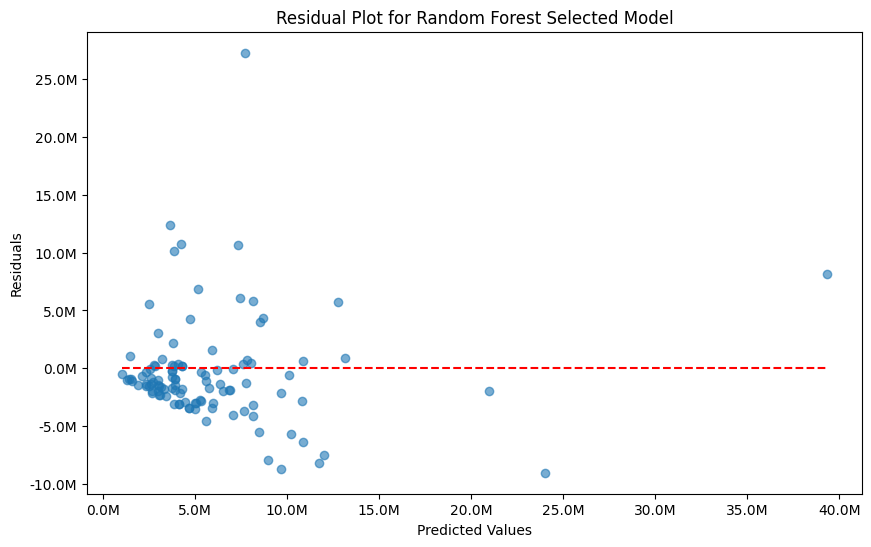

In [32]:
residuals_rf_selected_best = y_test_selected - y_pred_rf_selected_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf_selected_test, residuals_rf_selected_best, alpha=0.6)
plt.hlines(0, min(y_pred_rf_selected_test), max(y_pred_rf_selected_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Selected Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

XGBoost Selected

In [33]:
param_grid_xgb_selected = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

In [34]:
xgb_model_selected = xgb.XGBRegressor(random_state=42)
xgb_random_selected = RandomizedSearchCV(estimator=xgb_model_selected, param_distributions=param_grid_xgb_selected, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
xgb_random_selected.fit(X_train_selected, y_train_selected)
best_params_xgb_selected = xgb_random_selected.best_params_

# Best Parameters
xgb_model_selected_best = xgb.XGBRegressor(**best_params_xgb_selected, random_state=42)
xgb_model_selected_best.fit(X_train_selected, y_train_selected)
y_pred_xgb_selected_train = xgb_model_selected_best.predict(X_train_selected)
y_pred_xgb_selected_test = xgb_model_selected_best.predict(X_test_selected)

r2_xgb_selected_train = r2_score(y_train_selected, y_pred_xgb_selected_train)
r2_xgb_selected_test = r2_score(y_test_selected, y_pred_xgb_selected_test)
mse_xgb_selected_best = mean_squared_error(y_test_selected, y_pred_xgb_selected_test)
mae_xgb_selected_best = mean_absolute_error(y_test_selected, y_pred_xgb_selected_test)
generalization_gap_xgb_selected = r2_xgb_selected_train - r2_xgb_selected_test

# Feature Importance
importances_xgb_selected_best = xgb_model_selected_best.feature_importances_
feature_names_xgb_selected = X_train_selected.columns
feature_importance_df_xgb_selected = pd.DataFrame({
    'Feature': feature_names_xgb_selected,
    'Importance': importances_xgb_selected_best
}).sort_values(by='Importance', ascending=False)

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\692553537.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\692553537.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


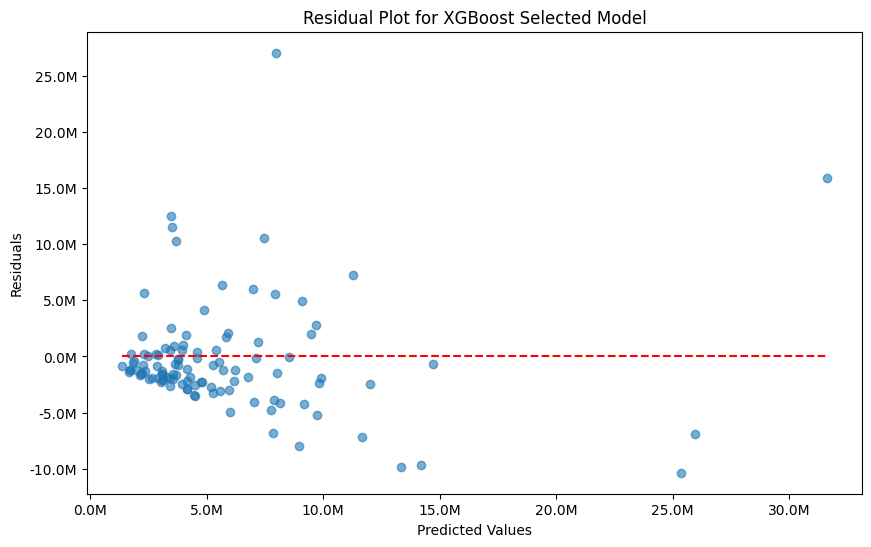

In [35]:
residuals_xgb_selected_best = y_test_selected - y_pred_xgb_selected_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb_selected_test, residuals_xgb_selected_best, alpha=0.6)
plt.hlines(0, min(y_pred_xgb_selected_test), max(y_pred_xgb_selected_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost Selected Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

ElasticNet Selected

In [36]:
param_grid_elasticnet_selected = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}

In [37]:
elasticnet_model_selected = ElasticNet(random_state=42)
elasticnet_random_selected = RandomizedSearchCV(estimator=elasticnet_model_selected, param_distributions=param_grid_elasticnet_selected, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
elasticnet_random_selected.fit(X_train_selected, y_train_selected)
best_params_elasticnet_selected = elasticnet_random_selected.best_params_

# Best Parameters
elasticnet_model_selected_best = ElasticNet(**best_params_elasticnet_selected, random_state=42)
elasticnet_model_selected_best.fit(X_train_selected, y_train_selected)
y_pred_elasticnet_selected_train = elasticnet_model_selected_best.predict(X_train_selected)
y_pred_elasticnet_selected_test = elasticnet_model_selected_best.predict(X_test_selected)

r2_elasticnet_selected_train = r2_score(y_train_selected, y_pred_elasticnet_selected_train)
r2_elasticnet_selected_test = r2_score(y_test_selected, y_pred_elasticnet_selected_test)
mse_elasticnet_selected_best = mean_squared_error(y_test_selected, y_pred_elasticnet_selected_test)
mae_elasticnet_selected_best = mean_absolute_error(y_test_selected, y_pred_elasticnet_selected_test)
generalization_gap_elasticnet_selected = r2_elasticnet_selected_train - r2_elasticnet_selected_test

# Feature Importance
elasticnet_coefficients_selected = elasticnet_model_selected_best.coef_
feature_names_elasticnet_selected = X_train_selected.columns
feature_importance_df_elasticnet_selected = pd.DataFrame({
    'Feature': feature_names_elasticnet_selected,
    'Coefficient': elasticnet_coefficients_selected
}).sort_values(by='Coefficient', key=abs, ascending=False)

c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 35 is smaller than n_iter=100. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 10 folds for each of 35 candidates, totalling 350 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3963279389.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3963279389.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


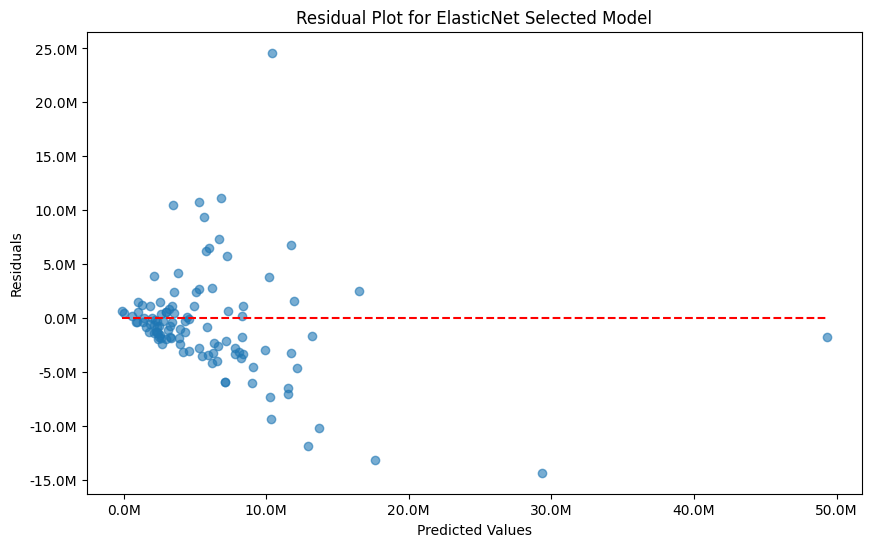

In [38]:
# Residual Plot
residuals_elasticnet_selected_best = y_test_selected - y_pred_elasticnet_selected_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_elasticnet_selected_test, residuals_elasticnet_selected_best, alpha=0.6)
plt.hlines(0, min(y_pred_elasticnet_selected_test), max(y_pred_elasticnet_selected_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for ElasticNet Selected Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

Model Training - Core

In [39]:
X_train_core, X_test_core, y_train_core, y_test_core = train_test_split(X_core, y, test_size=0.2, random_state=42)

Linear Regression - Core

In [40]:
linear_model_core = LinearRegression()
linear_model_core.fit(X_train_core, y_train_core)
y_pred_lr_core_train = linear_model_core.predict(X_train_core)
y_pred_lr_core = linear_model_core.predict(X_test_core)
r2_lr_core_train = r2_score(y_train_core, y_pred_lr_core_train)
r2_lr_core = r2_score(y_test_core, y_pred_lr_core)
mse_lr_core = mean_squared_error(y_test_core, y_pred_lr_core)
mae_lr_core = mean_absolute_error(y_test_core, y_pred_lr_core)
generalization_gap_lr_core = r2_lr_core_train - r2_lr_core

Random Forest - Core

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\2722861392.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\2722861392.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


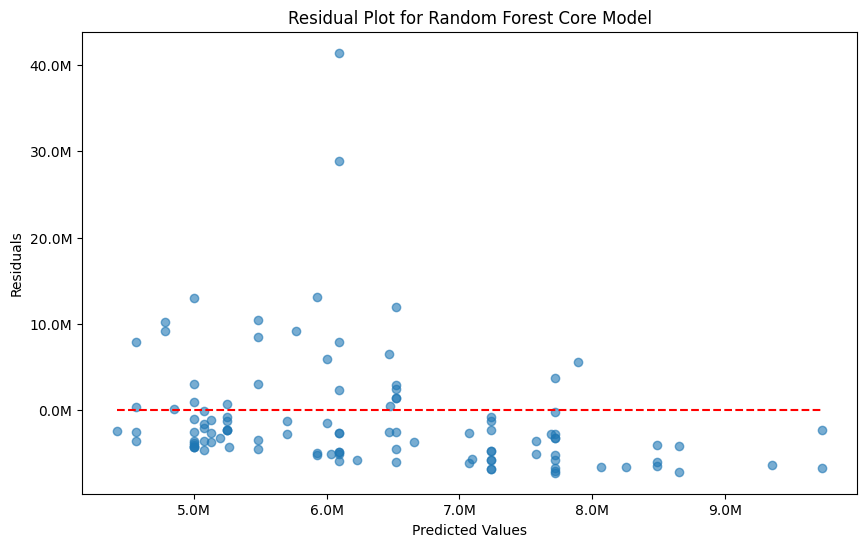

In [41]:
param_grid_rf_core = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'max_features': [None, 'sqrt', 'log2'],
    'max_leaf_nodes': [None, 10, 20, 30]
}

rf_model_core = RandomForestRegressor(random_state=42)
rf_random_core = RandomizedSearchCV(estimator=rf_model_core, param_distributions=param_grid_rf_core, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
rf_random_core.fit(X_train_core, y_train_core)
best_params_rf_core = rf_random_core.best_params_

# Best Parameters
rf_model_core_best = RandomForestRegressor(**best_params_rf_core, random_state=42)
rf_model_core_best.fit(X_train_core, y_train_core)
y_pred_rf_core_train = rf_model_core_best.predict(X_train_core)
y_pred_rf_core_test = rf_model_core_best.predict(X_test_core)

r2_rf_core_train = r2_score(y_train_core, y_pred_rf_core_train)
r2_rf_core_test = r2_score(y_test_core, y_pred_rf_core_test)
mse_rf_core_best = mean_squared_error(y_test_core, y_pred_rf_core_test)
mae_rf_core_best = mean_absolute_error(y_test_core, y_pred_rf_core_test)
generalization_gap_rf_core = r2_rf_core_train - r2_rf_core_test

# Feature Importance
rf_importances_core = rf_model_core_best.feature_importances_
feature_names_core = X_train_core.columns
feature_importance_rf_core = pd.DataFrame({
    'Feature': feature_names_core,
    'Importance': rf_importances_core
}).sort_values(by='Importance', ascending=False)

# Residual Plot
residuals_rf_core_best = y_test_core - y_pred_rf_core_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_rf_core_test, residuals_rf_core_best, alpha=0.6)
plt.hlines(0, min(y_pred_rf_core_test), max(y_pred_rf_core_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for Random Forest Core Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

XGBoost - Core

Fitting 10 folds for each of 100 candidates, totalling 1000 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\2420575329.py:45: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\2420575329.py:46: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


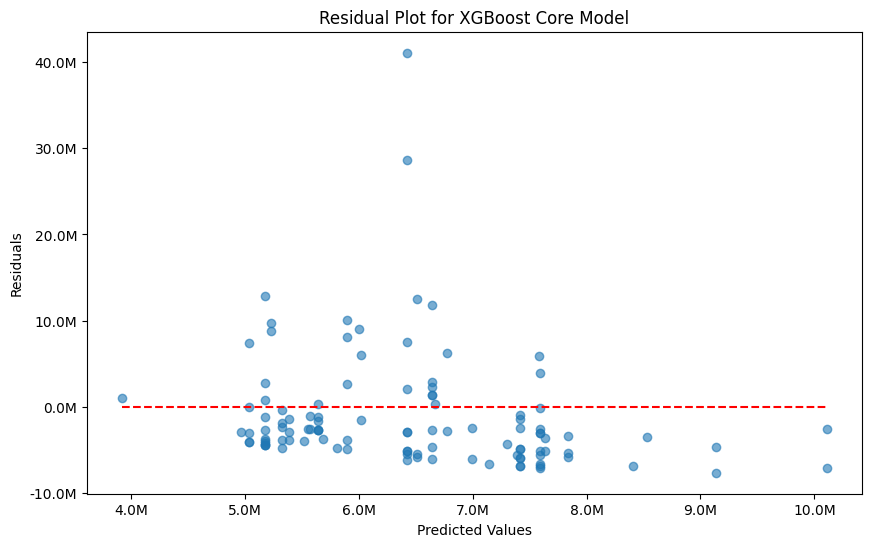

In [42]:
param_grid_xgb_core = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_child_weight': [1, 2, 3, 4, 5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5]
}

xgb_model_core = xgb.XGBRegressor(random_state=42)
xgb_random_core = RandomizedSearchCV(estimator=xgb_model_core, param_distributions=param_grid_xgb_core, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
xgb_random_core.fit(X_train_core, y_train_core)
best_params_xgb_core = xgb_random_core.best_params_

# Best Parameters
xgb_model_core_best = xgb.XGBRegressor(**best_params_xgb_core, random_state=42)
xgb_model_core_best.fit(X_train_core, y_train_core)
y_pred_xgb_core_train = xgb_model_core_best.predict(X_train_core)
y_pred_xgb_core_test = xgb_model_core_best.predict(X_test_core)

r2_xgb_core_train = r2_score(y_train_core, y_pred_xgb_core_train)
r2_xgb_core_test = r2_score(y_test_core, y_pred_xgb_core_test)
mse_xgb_core_best = mean_squared_error(y_test_core, y_pred_xgb_core_test)
mae_xgb_core_best = mean_absolute_error(y_test_core, y_pred_xgb_core_test)
generalization_gap_xgb_core = r2_xgb_core_train - r2_xgb_core_test

# Feature Importance
importances_xgb_core_best = xgb_model_core_best.feature_importances_
feature_names_xgb_core = X_train_core.columns
feature_importance_df_xgb_core = pd.DataFrame({
    'Feature': feature_names_xgb_core,
    'Importance': importances_xgb_core_best
}).sort_values(by='Importance', ascending=False)

# Residual Plot
residuals_xgb_core_best = y_test_core - y_pred_xgb_core_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_xgb_core_test, residuals_xgb_core_best, alpha=0.6)
plt.hlines(0, min(y_pred_xgb_core_test), max(y_pred_xgb_core_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for XGBoost Core Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

ElasticNet - Core

c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 35 is smaller than n_iter=100. Running 35 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1417622989.py:39: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])


Fitting 10 folds for each of 35 candidates, totalling 350 fits


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1417622989.py:40: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


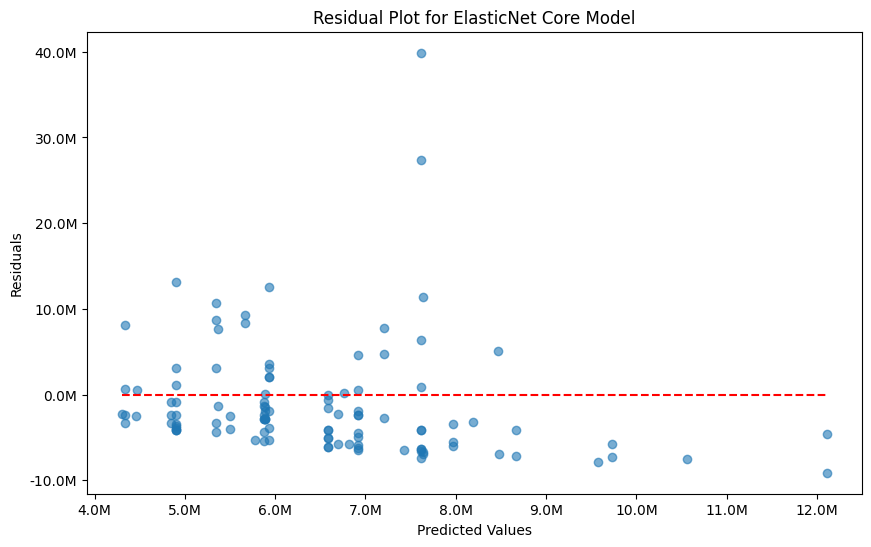

In [43]:
param_grid_elasticnet_core = {
    'alpha': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9]
}
elasticnet_model_core = ElasticNet(random_state=42)
elasticnet_random_core = RandomizedSearchCV(estimator=elasticnet_model_core, param_distributions=param_grid_elasticnet_core, n_iter=100, cv=10, verbose=2, random_state=42, n_jobs=-1)
elasticnet_random_core.fit(X_train_core, y_train_core)
best_params_elasticnet_core = elasticnet_random_core.best_params_

# Best Parameters
elasticnet_model_core_best = ElasticNet(**best_params_elasticnet_core, random_state=42)
elasticnet_model_core_best.fit(X_train_core, y_train_core)
y_pred_elasticnet_core_train = elasticnet_model_core_best.predict(X_train_core)
y_pred_elasticnet_core_test = elasticnet_model_core_best.predict(X_test_core)

r2_elasticnet_core_train = r2_score(y_train_core, y_pred_elasticnet_core_train)
r2_elasticnet_core_test = r2_score(y_test_core, y_pred_elasticnet_core_test)
mse_elasticnet_core_best = mean_squared_error(y_test_core, y_pred_elasticnet_core_test)
mae_elasticnet_core_best = mean_absolute_error(y_test_core, y_pred_elasticnet_core_test)
generalization_gap_elasticnet_core = r2_elasticnet_core_train - r2_elasticnet_core_test

# Feature Importance
elasticnet_coefficients_core = elasticnet_model_core_best.coef_
feature_names_elasticnet_core = X_train_core.columns
feature_importance_df_elasticnet_core = pd.DataFrame({
    'Feature': feature_names_elasticnet_core,
    'Coefficient': elasticnet_coefficients_core
}).sort_values(by='Coefficient', key=abs, ascending=False)

# Residual Plot
residuals_elasticnet_core_best = y_test_core - y_pred_elasticnet_core_test
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_elasticnet_core_test, residuals_elasticnet_core_best, alpha=0.6)
plt.hlines(0, min(y_pred_elasticnet_core_test), max(y_pred_elasticnet_core_test), colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot for ElasticNet Core Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

Evaluation

In [44]:
evaluation_metrics = {
    "Model": ["Linear Regression", "Linear Regression Selected", "Linear Regression (Core)", "Random Forest", "Random Forest Selected",
              "Random Forest (Core)", "XGBoost", "XGBoost Selected", "XGBoost (Core)", "ElasticNet", "ElasticNet Selected", "ElasticNet (Core)"],
    "R-squared": [r2_lr, r2_lr_selected, r2_lr_core, r2_rf_baseline_test, r2_rf_selected_test, r2_rf_core_test, r2_xgb_baseline_test, r2_xgb_selected_test,
                  r2_xgb_core_test, r2_elasticnet_baseline_test, r2_elasticnet_selected_test, r2_elasticnet_core_test],
    "Mean Squared Error": [mse_lr, mse_lr_selected, mse_lr_core, mse_rf_baseline_best, mse_rf_selected_best, mse_rf_core_best, mse_xgb_baseline_best, mse_xgb_selected_best,
                           mse_xgb_core_best, mse_elasticnet_baseline_best, mse_elasticnet_selected_best, mse_elasticnet_core_best],
    "Mean Absolute Error": [mae_lr, mae_lr_selected, mae_lr_core, mae_rf_baseline_best, mae_rf_selected_best, mae_rf_core_best, mae_xgb_baseline_best, mae_xgb_selected_best, mae_xgb_core_best,
                            mae_elasticnet_baseline_best, mae_elasticnet_selected_best, mae_elasticnet_core_best],
    "Generalization Gap": [generalization_gap_lr, generalization_gap_lr_selected, generalization_gap_lr_core, generalization_gap_rf_baseline, generalization_gap_rf_selected, generalization_gap_rf_core, 
                           generalization_gap_xgb_baseline, generalization_gap_xgb_selected, generalization_gap_xgb_core, generalization_gap_elasticnet_baseline, generalization_gap_elasticnet_selected, generalization_gap_elasticnet_core]
}

evaluation_df = pd.DataFrame(evaluation_metrics)
print(evaluation_df)



                         Model  R-squared  Mean Squared Error  \
0            Linear Regression   0.036647        4.348001e+13   
1   Linear Regression Selected   0.453878        2.464868e+13   
2     Linear Regression (Core)  -0.120511        5.057321e+13   
3                Random Forest   0.475525        2.367170e+13   
4       Random Forest Selected   0.524262        2.147197e+13   
5         Random Forest (Core)  -0.082933        4.887715e+13   
6                      XGBoost   0.444408        2.507611e+13   
7             XGBoost Selected   0.461798        2.429126e+13   
8               XGBoost (Core)  -0.066871        4.815219e+13   
9                   ElasticNet   0.502835        2.243906e+13   
10         ElasticNet Selected   0.464798        2.415584e+13   
11           ElasticNet (Core)  -0.055038        4.761816e+13   

    Mean Absolute Error  Generalization Gap  
0          4.614075e+06            0.844405  
1          3.250666e+06            0.126907  
2          5.024

SHAP

In [45]:
import shap

c:\Users\damon\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SHAP: Random Forest Selected

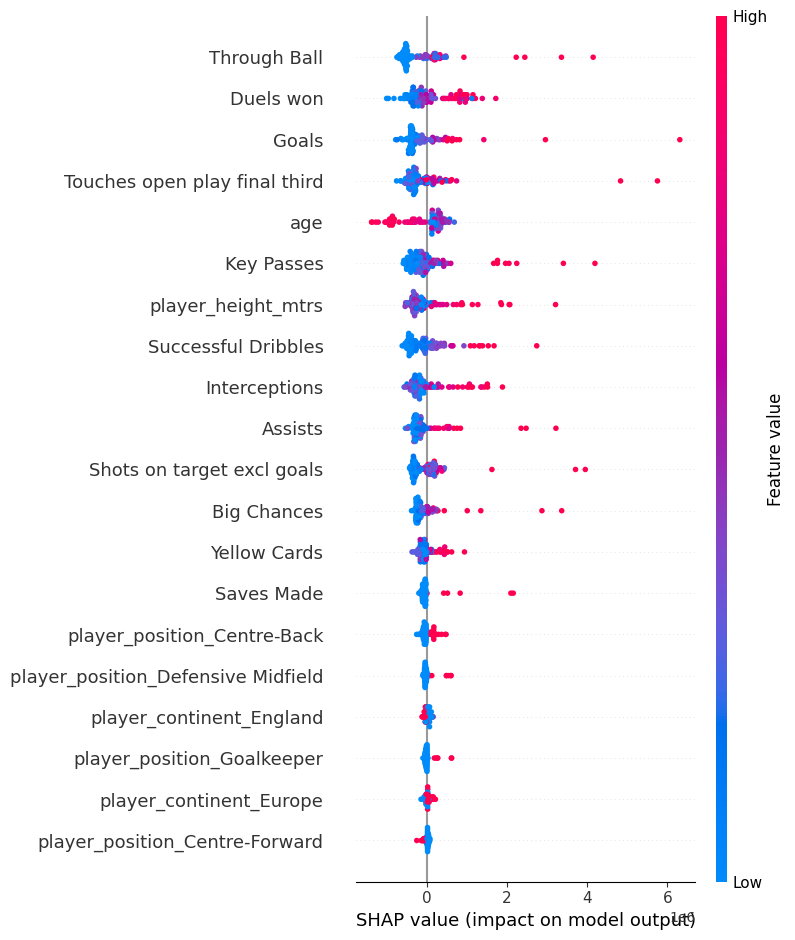

In [46]:
X_train_selected = X_train_selected.apply(pd.to_numeric)
X_test_selected = X_test_selected.apply(pd.to_numeric)

# Use SHAP's TreeExplainer for Random Forest selected model
explainer_rf_selected = shap.TreeExplainer(rf_model_selected_best)
shap_values_rf_selected = explainer_rf_selected.shap_values(X_test_selected)

# SHAP summary plot for Random Forest selected model
shap.summary_plot(shap_values_rf_selected, X_test_selected)


SHAP: ElectricNet Selected

Using 428 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 108/108 [00:28<00:00,  3.73it/s]


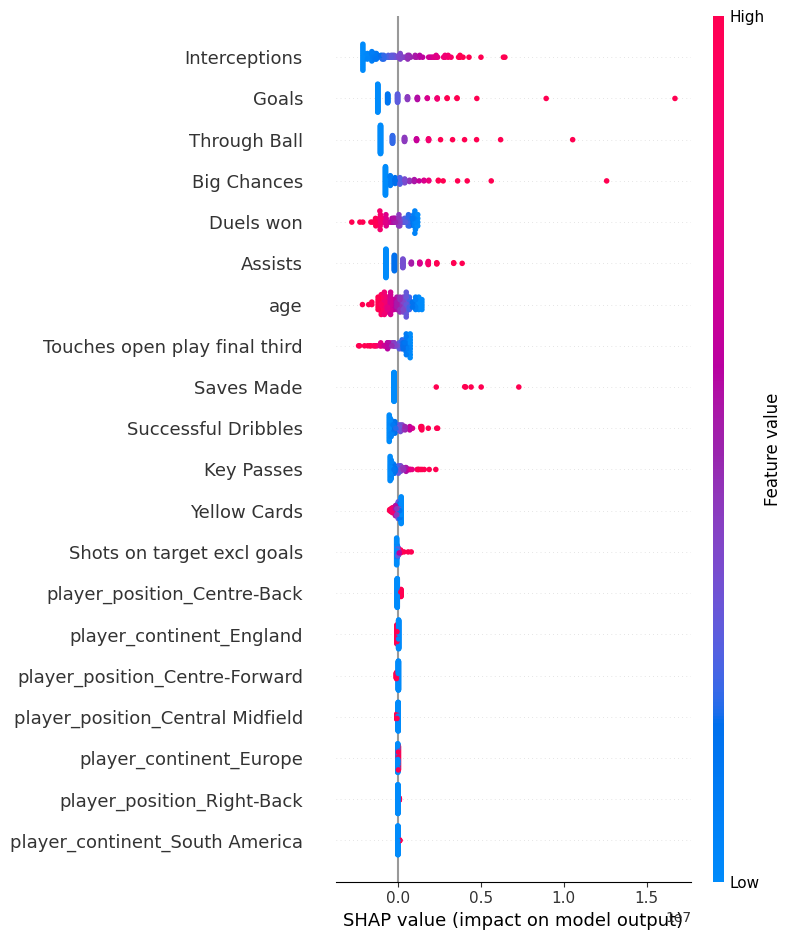

In [47]:

X_train_selected = X_train_selected.apply(pd.to_numeric)
X_test_selected = X_test_selected.apply(pd.to_numeric)

# Use SHAP's KernelExplainer for ElasticNet selected model
explainer_elasticnet_selected = shap.KernelExplainer(elasticnet_model_selected_best.predict, X_train_selected)
shap_values_elasticnet_selected = explainer_elasticnet_selected.shap_values(X_test_selected, nsamples=100)

# SHAP summary plot for ElasticNet selected model
shap.summary_plot(shap_values_elasticnet_selected, X_test_selected)


ElasticNet Interactions

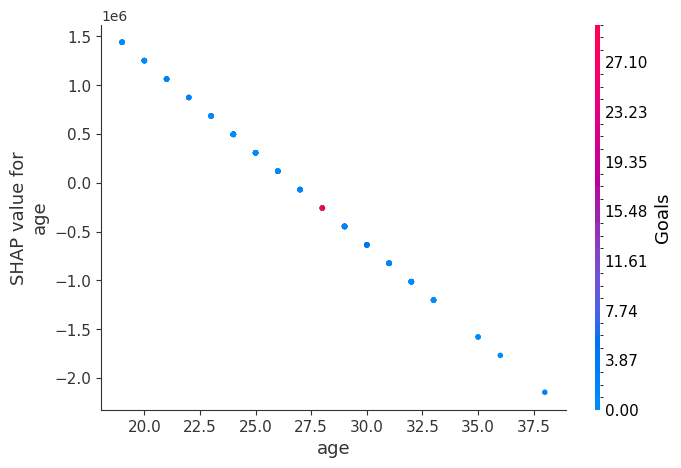

In [48]:
shap.dependence_plot('age', shap_values_elasticnet_selected, X_test_selected, interaction_index='Goals')

In [49]:
shap.initjs()
shap.force_plot(explainer_elasticnet_selected.expected_value, shap_values_elasticnet_selected[0,:], X_test_selected.iloc[0,:])


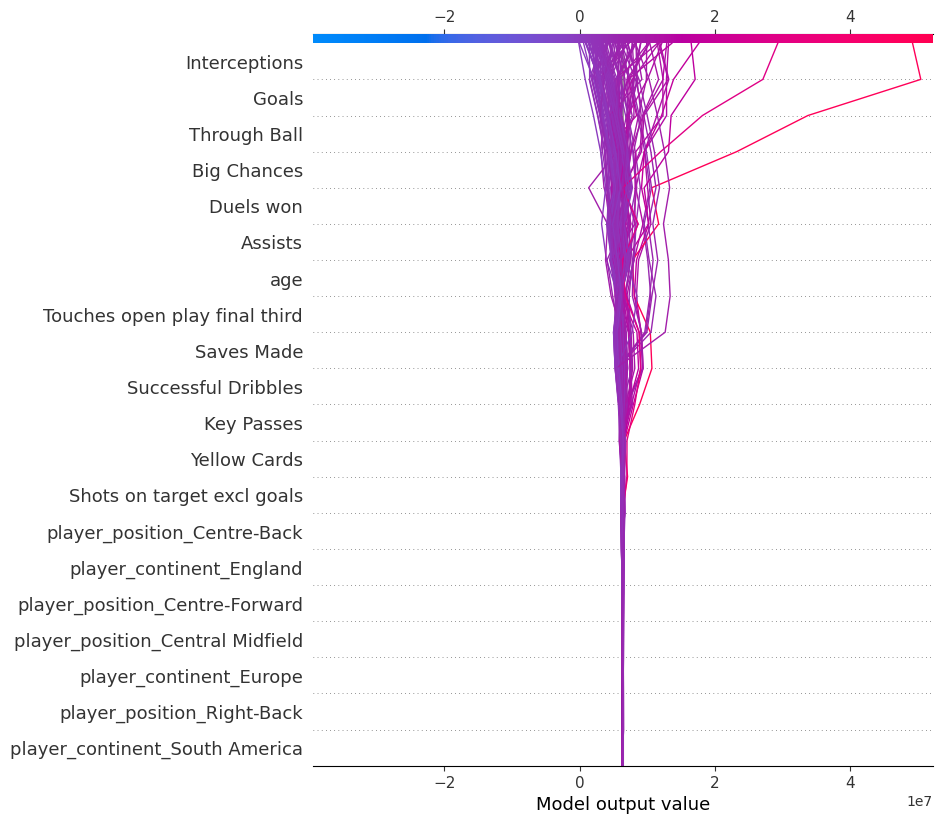

In [50]:
# SHAP decision plot for a specific prediction
shap.decision_plot(explainer_elasticnet_selected.expected_value, shap_values_elasticnet_selected, X_test_selected)


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3493464460.py:16: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3493464460.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


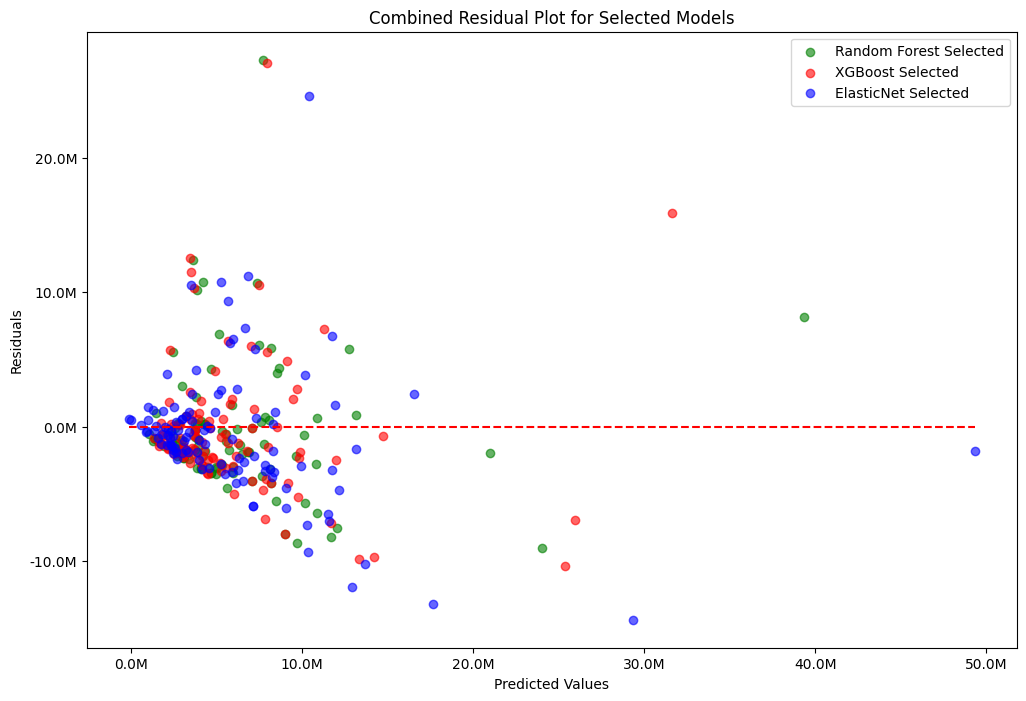

In [52]:
# Combined residual plot
plt.figure(figsize=(12, 8))

plt.scatter(y_pred_rf_selected_test, residuals_rf_selected_best, alpha=0.6, label='Random Forest Selected', color='green')
plt.scatter(y_pred_xgb_selected_test, residuals_xgb_selected_best, alpha=0.6, label='XGBoost Selected', color='red')
plt.scatter(y_pred_elasticnet_selected_test, residuals_elasticnet_selected_best, alpha=0.6, label='ElasticNet Selected', color='blue')

plt.hlines(0, min(min(y_pred_rf_selected_test), min(y_pred_xgb_selected_test), min(y_pred_elasticnet_selected_test)),
           max(max(y_pred_rf_selected_test), max(y_pred_xgb_selected_test), max(y_pred_elasticnet_selected_test)),
           colors='r', linestyles='dashed')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Combined Residual Plot for Selected Models')
plt.legend()
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()

In [53]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3134184671.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\3134184671.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


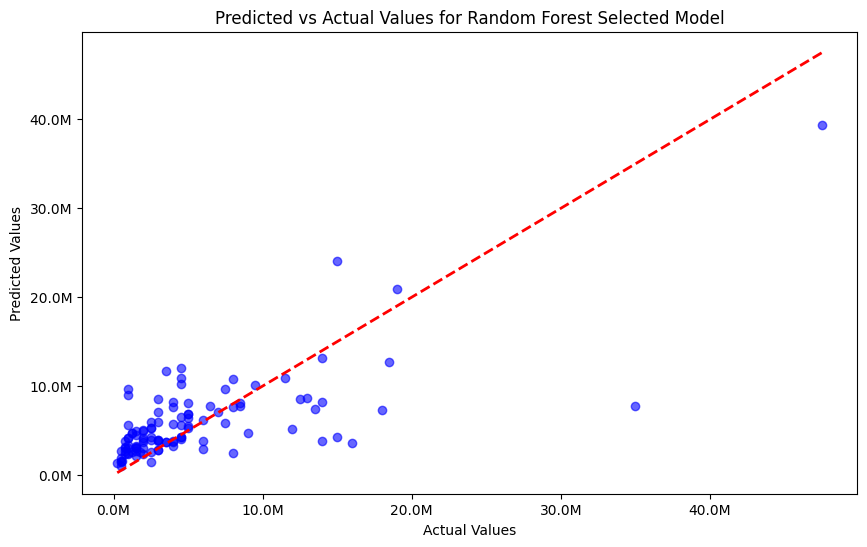

In [54]:

# Scatterplot for Random Forest Selected Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_selected, y_pred_rf_selected_test, alpha=0.6, color='blue')
plt.plot([min(y_test_selected), max(y_test_selected)], [min(y_test_selected), max(y_test_selected)], color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for Random Forest Selected Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()


C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1424388952.py:9: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
C:\Users\damon\AppData\Local\Temp\ipykernel_81356\1424388952.py:10: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])


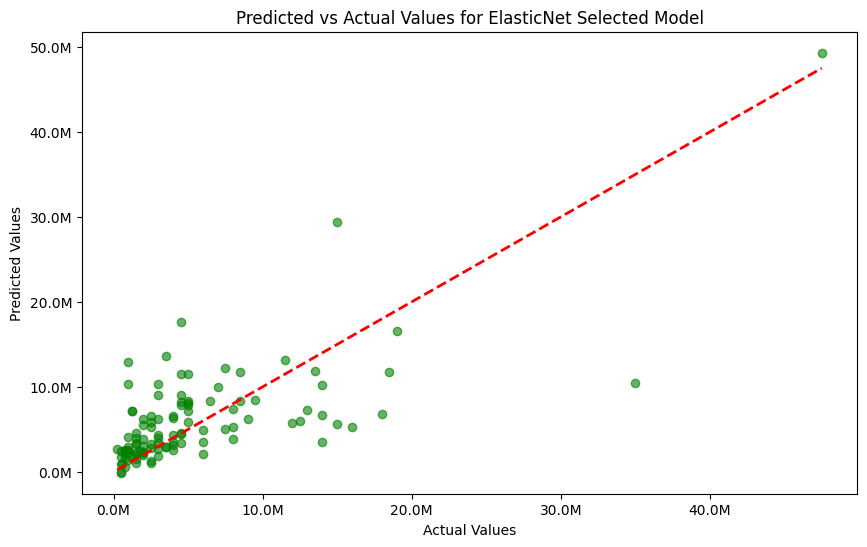

In [55]:
# Scatterplot for ElasticNet Selected Model
plt.figure(figsize=(10, 6))
plt.scatter(y_test_selected, y_pred_elasticnet_selected_test, alpha=0.6, color='green')
plt.plot([min(y_test_selected), max(y_test_selected)], [min(y_test_selected), max(y_test_selected)], color='red', linestyle='dashed', linewidth=2)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Predicted vs Actual Values for ElasticNet Selected Model')
ticks = plt.gca().get_xticks()
plt.gca().set_xticklabels(['{:.1f}M'.format(t/1e6) for t in ticks])
plt.gca().set_yticklabels(['{:.1f}M'.format(t/1e6) for t in plt.gca().get_yticks()])
plt.show()
